In [2]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [14]:
import importlib
import modules.beta_trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_hopper

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.beta_trainer)
importlib.reload(env.custom_hopper)

# Re-import the specific functions into the global namespace
from modules.beta_trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-source-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-target-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/gymnasium/envs/registration.py:644: UserWarning: WARN: Overriding environment CustomHopper-sh

In [3]:
from modules.beta_trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

In [15]:
config = {
    'env_id': 'CustomHopper-source-v0',
    'algo': 'sac',
    'seed': 42,
    'timesteps': 1_000_000,
    'n_envs': 4,
    'vectorize': True,
    'normalize': True, 
    'lr': 1e-3,
    'gradient_steps': 2,
    'train_freq': 1,
    
    'mode': "udr"

}

In [16]:
# Training
train_agent(config, model_name="udr_baseline_2x", log_dir="./logs/udr_experiment_2x/")

Training with mode: udr
--- STARTING NEW TRAINING ---
Using cpu device
Skipping DoraemonCallback for mode: udr
Logging to ./tensorboard_logs/SAC_30
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.2     |
|    ep_rew_mean     | 9.61     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1185     |
|    time_elapsed    | 0        |
|    total_timesteps | 108      |
| train/             |          |
|    actor_loss      | -2.28    |
|    critic_loss     | 6.25     |
|    ent_coef        | 1        |
|    ent_coef_loss   | -0.00249 |
|    learning_rate   | 0.001    |
|    n_updates       | 2        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17       |
|    ep_rew_mean     | 10.1     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 573      |
|    time_elapsed    | 0        |
| 

(<stable_baselines3.sac.sac.SAC at 0x10e839670>,
 None)

In [ ]:
# ONLY USE IF TRAINING WAS INTERRUPTED AND YOU HAVE CHECKPOINTS

import os
import re

# CHECKPOINT VERIFICATION

checkpoint_dir = "./logs/checkpoints"
if os.path.exists(checkpoint_dir):
    print("Files found:", os.listdir(checkpoint_dir))
else:
    print("No checkpoints found! The interrupt save didn't work.")


# RESUME TRAINING FROM CHECKPOINT

# 1. Find the latest checkpoint step
log_dir = "./logs/"
ckpt_dir = os.path.join(log_dir, "checkpoints")

latest_step = None
if os.path.exists(ckpt_dir):
    # regex to find numbers in filenames
    steps = [int(re.search(r'\d+', f).group()) for f in os.listdir(ckpt_dir) if "model_" in f]
    if steps:
        latest_step = max(steps)

print(f"Resuming from step: {latest_step}")

# 2. Resume Training
if latest_step is not None:
    # Pass the step number to resume_step
    model, env, doraemon_cb = train_agent(config, log_dir=log_dir, resume_step=latest_step)
else:
    print("Could not find a checkpoint to resume.")

In [12]:
# Used to visualize training metrics through TensorBoard
! tensorboard --logdir ./tensorboard_logs/

# Note: if you want to run Tensorboard from terminal, simply use the command above

/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Data loaded. Updates found: 541


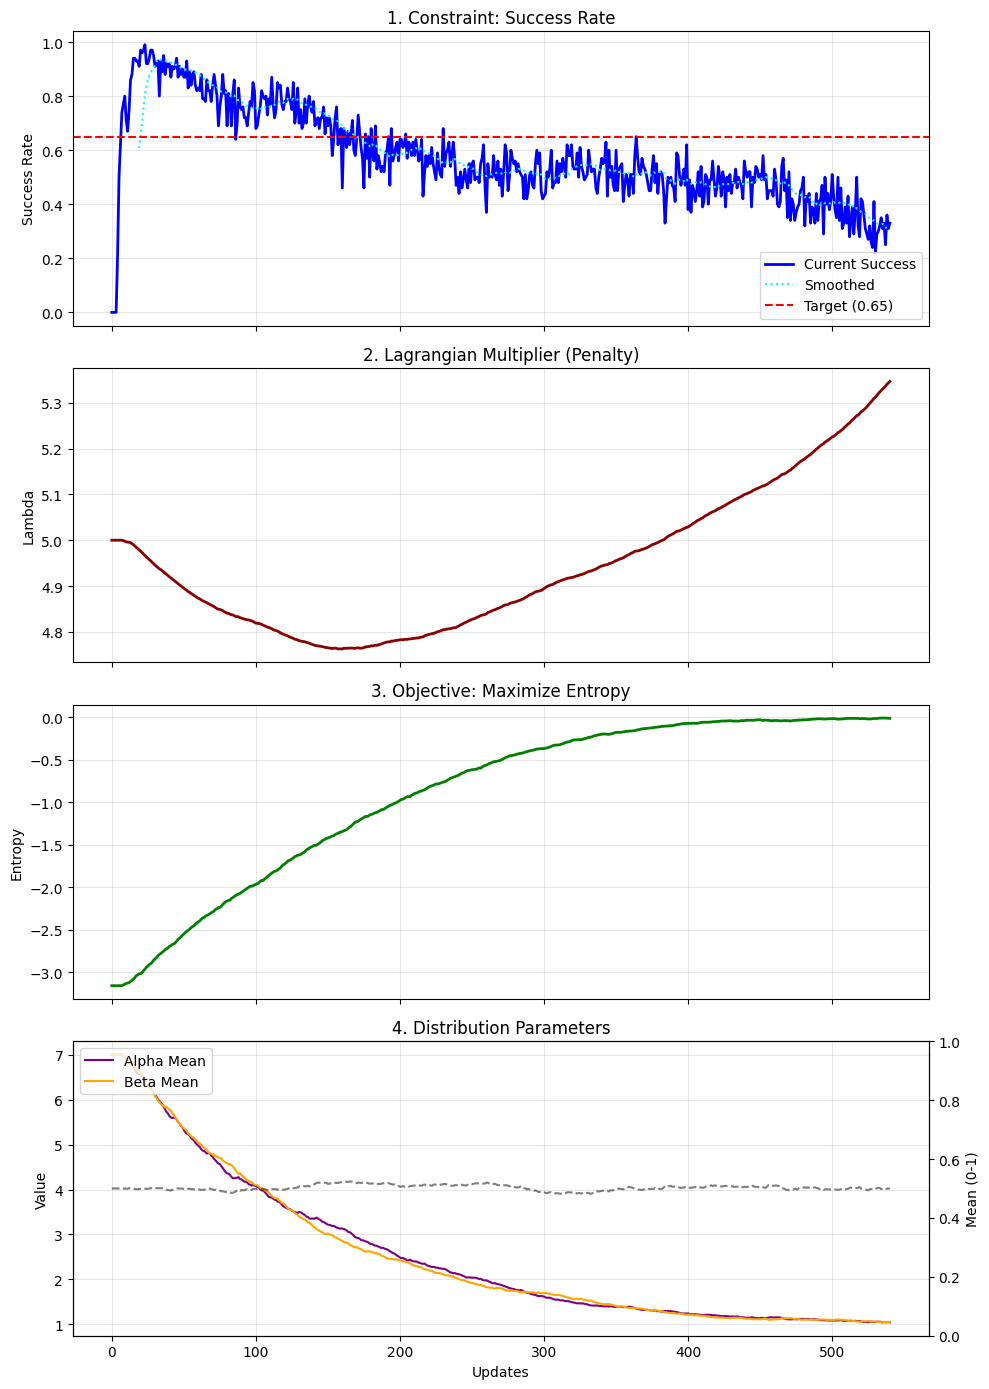

In [10]:
import json
import numpy as np

class DoraemonMockCallback:
    def __init__(self, json_path):
        # Load the JSON data
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Extract the history
        self.history = data.get("history", {}) 
        
        print(f"Data loaded. Updates found: {len(self.history.get('entropy', []))}")


doraemon_cb = DoraemonMockCallback('logs/doraemon_state_20000000.json')

plot_doraemon_dynamics(doraemon_cb)

In [14]:
from modules.utils import *
from stable_baselines3 import SAC

# Define the raw environments
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

# Reconstruct the model name used in training
model_name = f"{config['algo']}_doraemon_{config['seed']}"
model_name = "final"

print("Caricamento modello da ./logs/udr_experiment/udr_baseline.zip ...")
model = SAC.load("./logs/udr_experiment/udr_baseline", device="cpu")

# Run evaluation
evaluate_sim2real(model, source_env, target_env, log_dir="./logs/", model_name=model_name)

Caricamento modello da ./logs/udr_experiment/udr_baseline.zip ...
Loaded Normalization stats from ./logs//final_vecnormalize.pkl


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



--- Evaluating on SOURCE Env (Simulation) ---
Reward: 43.91 +/- 0.93
Length: 25.70 +/- 0.56 steps

--- Evaluating on TARGET Env (Real/Shifted) ---
Reward: 46.95 +/- 1.24
Length: 28.70 +/- 0.78 steps


(np.float64(43.90747263431549), np.float64(46.9465738594532))

Caricamento modello da ./logs/udr_experiment_2x/udr_baseline_2x.zip ...

Avvio valutazione robustezza su 9 configurazioni...
------------------------------------------------------------


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Shift -2.0 kg | Reward:  1376.61 +/-   9.41
Shift -1.5 kg | Reward:  1506.97 +/-   3.75
Shift -1.0 kg | Reward:  1582.02 +/-   2.81
Shift -0.5 kg | Reward:  1604.66 +/-  11.34
Shift +0.0 kg | Reward:  1655.24 +/-  10.39
Shift +0.5 kg | Reward:  1697.34 +/-  36.15
Shift +1.0 kg | Reward:  1434.61 +/- 115.02
Shift +1.5 kg | Reward:  1112.40 +/-  34.27
Shift +2.0 kg | Reward:  1197.56 +/-  54.91


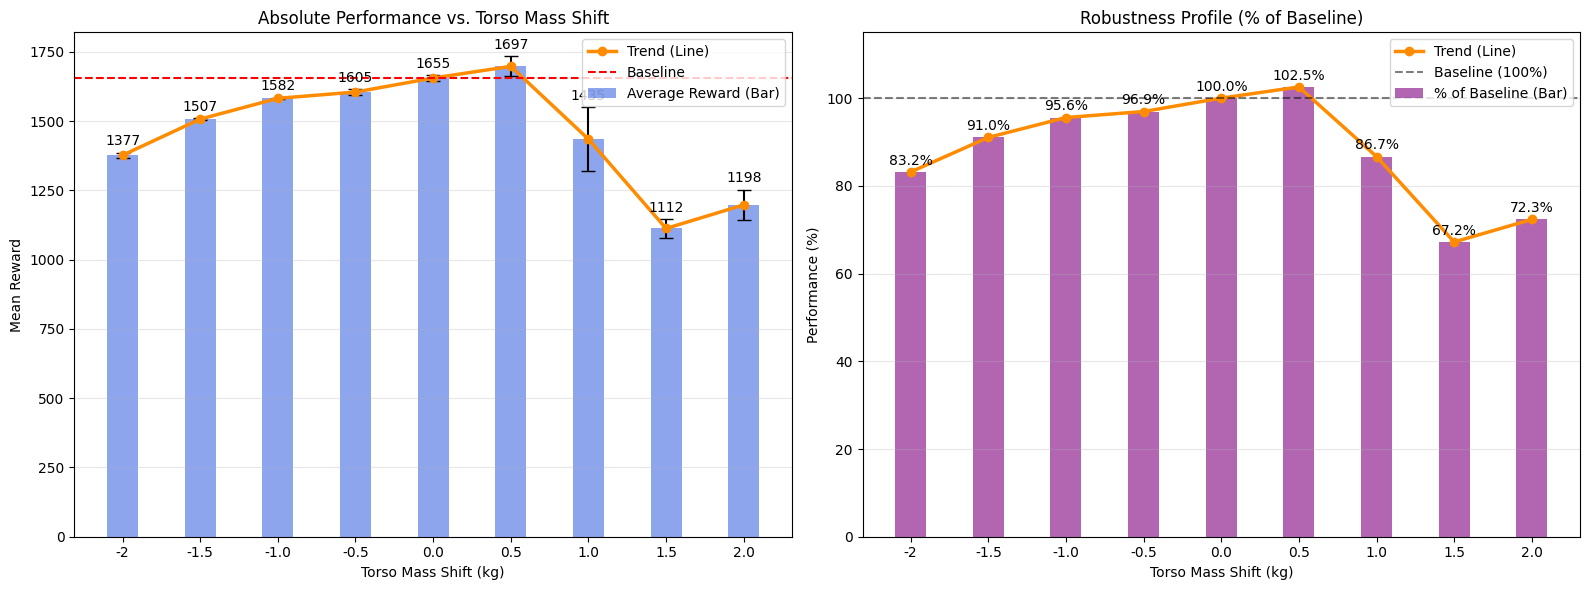

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

# --- 1. CARICAMENTO MODELLO ---
print("Caricamento modello da ./logs/udr_experiment_2x/udr_baseline_2x.zip ...")
model = SAC.load("./logs/udr_experiment_2x/udr_baseline_2x", device="cpu")

# print("Caricamento modello da ./logs/udr_experiment_1.1x/udr_baseline_1.1x.zip ...")
# model = SAC.load("./logs/udr_experiment_1.1x/udr_baseline_1.1x", device="cpu")

# print("Caricamento modello da ./logs/udr_experiment_10x/udr_baseline_10x.zip ...")
# model = SAC.load("./logs/udr_experiment_10x/udr_baseline_10x", device="cpu")

# --- 3. CONFIGURAZIONE ---
mass_shifts = [-2, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza su {len(mass_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in mass_shifts:
    env = gym.make("CustomHopper-shift-v0", mass_shift=shift)
    env = DummyVecEnv([lambda: env])
    
    norm_path = f"./logs/udr_experiment_2x/udr_baseline_2x_vecnormalize.pkl"
    # norm_path = f"./logs/udr_experiment_1.1x/udr_baseline_1.1x_vecnormalize.pkl"
    # norm_path = f"./logs/udr_experiment_10x/udr_baseline_10x_vecnormalize.pkl"
    try:
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_reward = False   
    except FileNotFoundError:
        pass 

    episode_rewards, episode_lengths = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Shift {shift:+.1f} kg | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 5. PLOTTING (BARRE + CURVA) ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)

if 0.0 in mass_shifts:
    baseline_idx = mass_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(mass_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Torso Mass Shift')
ax1.set_xlabel('Torso Mass Shift (kg)')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(mass_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Torso Mass Shift (kg)')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(mass_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

Caricamento modello da ./logs/udr_experiment_1.1x/udr_baseline_1.1x.zip ...

Avvio valutazione robustezza su 13 configurazioni...
------------------------------------------------------------


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Shift -0.90 | Reward:  1859.97 +/-  44.67
Shift -0.60 | Reward:  1838.06 +/-  49.21
Shift -0.30 | Reward:  1847.65 +/-  48.06
Shift +0.00 | Reward:  1849.99 +/-  47.18
Shift +0.30 | Reward:  1861.36 +/-  46.45
Shift +0.60 | Reward:  1867.89 +/-  57.64
Shift +0.90 | Reward:  1865.37 +/-  53.82
Shift +1.20 | Reward:  1574.27 +/-  38.59
Shift +1.50 | Reward:  1536.82 +/-  77.53
Shift +1.80 | Reward:   547.73 +/-   9.50
Shift +2.10 | Reward:   446.68 +/-   3.70
Shift +2.40 | Reward:   378.83 +/-   2.06
Shift +2.70 | Reward:   308.59 +/-   1.90


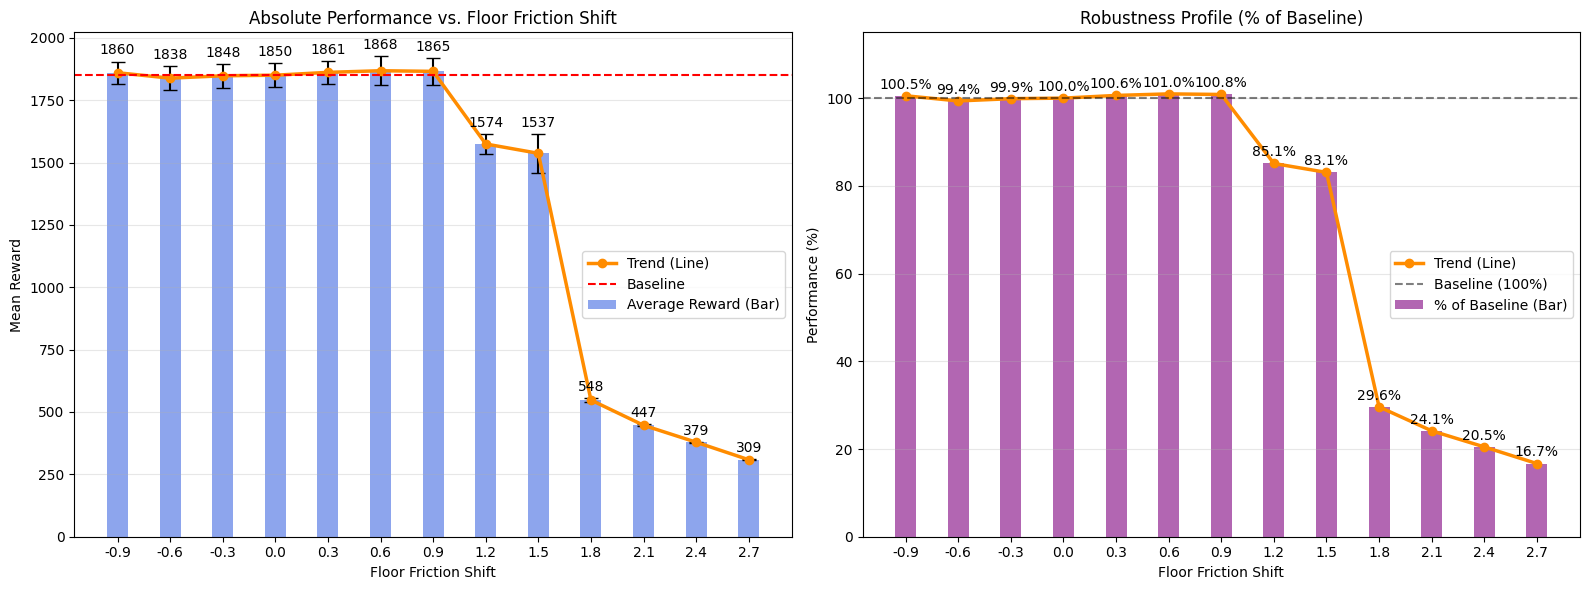

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.registration import register
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy

# --- 1. CARICAMENTO MODELLO ---
# print("Caricamento modello da ./logs/udr_experiment/udr_baseline.zip ...")
# model = SAC.load("./logs/udr_experiment/udr_baseline", device="cpu")

print("Caricamento modello da ./logs/udr_experiment_1.1x/udr_baseline_1.1x.zip ...")
model = SAC.load("./logs/udr_experiment_1.1x/udr_baseline_1.1x", device="cpu")

# print("Caricamento modello da ./logs/udr_experiment_10x/udr_baseline_10x.zip ...")
# model = SAC.load("./logs/udr_experiment_10x/udr_baseline_10x", device="cpu")

# --- 3. CONFIGURAZIONE ---
floor_friction_shifts = [-0.9, -0.6, -0.3, 0.0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7]
n_eval_episodes = 20
results_mean = []
results_std = []

print(f"\nAvvio valutazione robustezza su {len(floor_friction_shifts)} configurazioni...")
print("-" * 60)

# --- 4. LOOP DI VALUTAZIONE ---
for shift in floor_friction_shifts:
    env = gym.make("CustomHopper-shift-v0", floor_friction_shift=shift, mass_shift=0.0)
    env = DummyVecEnv([lambda: env])
    
    # norm_path = f"./logs/udr_experiment/udr_baseline_vecnormalize.pkl"
    norm_path = f"./logs/udr_experiment_1.1x/udr_baseline_1.1x_vecnormalize.pkl"
    # norm_path = f"./logs/udr_experiment_10x/udr_baseline_10x_vecnormalize.pkl"
    try:
        env = VecNormalize.load(norm_path, env)
        env.training = False      
        env.norm_reward = False   
    except FileNotFoundError:
        pass 

    episode_rewards, episode_lengths = evaluate_policy(
        model, 
        env, 
        n_eval_episodes=n_eval_episodes, 
        deterministic=True, 
        return_episode_rewards=True
    )
    
    mean_r = np.mean(episode_rewards)
    std_r = np.std(episode_rewards)
    results_mean.append(mean_r)
    results_std.append(std_r)
    
    print(f"Shift {shift:+.2f} | Reward: {mean_r:8.2f} +/- {std_r:6.2f}")
    
    env.close()

# --- 5. PLOTTING (BARRE + CURVA) ---
results_mean = np.array(results_mean)
results_std = np.array(results_std)

if 0.0 in floor_friction_shifts:
    baseline_idx = floor_friction_shifts.index(0.0)
    baseline_reward = results_mean[baseline_idx]
else:
    baseline_reward = np.max(results_mean)

percentages = (results_mean / baseline_reward) * 100

# Creazione Grafici
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bar_width = 0.4
x_pos = np.arange(len(floor_friction_shifts))

# --- Grafico A: Performance Assoluta ---
# 1. Le Barre
bars1 = ax1.bar(x_pos, results_mean, yerr=results_std, align='center', 
               alpha=0.6, ecolor='black', capsize=5, width=bar_width, 
               color='royalblue', label='Average Reward (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax1.plot(x_pos, results_mean, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax1.axhline(y=baseline_reward, color='red', linestyle='--', linewidth=1.5, label='Baseline')
ax1.set_title('Absolute Performance vs. Floor Friction Shift')
ax1.set_xlabel('Floor Friction Shift')
ax1.set_ylabel('Mean Reward')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(floor_friction_shifts)
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend()

# Etichette barre
ax1.bar_label(bars1, fmt='%.0f', padding=3)


# --- Grafico B: Performance Relativa ---
# 1. Le Barre
bars2 = ax2.bar(x_pos, percentages, align='center', 
                alpha=0.6, width=bar_width, 
                color='purple', label='% of Baseline (Bar)')

# 2. La Curva in sovraimpressione (Trend)
ax2.plot(x_pos, percentages, color='darkorange', marker='o', linewidth=2.5, label='Trend (Line)')

ax2.axhline(y=100.0, color='black', linestyle='--', alpha=0.5, label='Baseline (100%)')
ax2.set_title('Robustness Profile (% of Baseline)')
ax2.set_xlabel('Floor Friction Shift')
ax2.set_ylabel('Performance (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(floor_friction_shifts)
ax2.set_ylim(0, max(115, np.max(percentages) + 10)) 
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend()

# Etichette barre
ax2.bar_label(bars2, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

In [ ]:
# RENDERING THE TRAINED AGENT

import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import time

# --- CONFIGURATION ---
# Use the same 'model_name' from your previous cell, or type it manually here
# e.g., model_name = "SAC_doraemon_0"
env_to_render = 'CustomHopper-source-v0' # Change to 'target' to see the Real/Shifted env

# 1. Setup the Environment with Rendering Enabled
# render_mode="human" creates the popup window
env = DummyVecEnv([lambda: gym.make(env_to_render, render_mode="human")])

# 2. Load the Normalization Statistics (CRITICAL)
# If you skip this, the agent will see "wrong" numbers and fail immediately
norm_path = f"./logs/{model_name}_vecnormalize.pkl"
try:
    env = VecNormalize.load(norm_path, env)
    # We must disable training and reward normalization for inference
    env.training = False
    env.norm_reward = False
    print(f"Loaded Normalization stats from {norm_path}")
except FileNotFoundError:
    print("Warning: No normalization stats found. Running with RAW observations.")

# 3. Load the Trained Model
model_path = f"./logs/{model_name}_model.zip"
model = SAC.load(model_path)

# 4. The Simulation Loop
print(f"Starting rendering for {env_to_render}...")
obs = env.reset()

try:
    # Run for 1000 steps (or until you stop it)
    for _ in range(1000):
        # Get the action from the agent
        action, _ = model.predict(obs, deterministic=True)
        
        # Step the environment
        obs, rewards, dones, info = env.step(action)
        
        # Render the frame
        env.render()
        
        # Slow down slightly so you can see what's happening (Macs run this very fast)
        time.sleep(0.02)
        
        if dones[0]:
            print("Agent fell over! Resetting...")
            obs = env.reset()
            # time.sleep(1.0) # Pause briefly on failure if you want to see the crash

except KeyboardInterrupt:
    print("Simulation stopped by user.")
finally:
    env.close()

In [ ]:
env = gym.make("CustomHopper-shift-v0", mass_shift=shift)
env.unwrapped.model.geom_friction

In [ ]:
from env.custom_hopper import CustomHopper
import gymnasium as gym

env = CustomHopper(domain="source")

print("Body Masses:")
for i in range(env.unwrapped.model.body_mass.shape[0]):
    print(f"Body {env.unwrapped.model.body(i).name} mass: {env.unwrapped.model.body_mass[i]}")

print ("\nFriction coefficients:")
for i in range(env.unwrapped.model.geom_friction.shape[0]):
    print(f"Body {env.unwrapped.model.geom(i).name} friction: {env.unwrapped.model.geom_friction[i]}")

print ("\nDamping coefficients:")
for i in range(env.unwrapped.model.dof_damping.shape[0]):
    print(f"Body {env.unwrapped.model.joint(i).name} damping: {env.unwrapped.model.dof_damping[i]}")
